In [16]:
!pip install stable-baselines3[extra]
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install websockets>=15.0.0 --quiet
!pip install transformers --quiet
!pip install newsapi-python --quiet
!pip install alpaca-py --quiet

zsh:1: no matches found: stable-baselines3[extra]
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /private/var/folders/sc/40gcq14x2cng8czg1s_vpkbr0000gn/T/pip-req-build-57y484v7
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /private/var/folders/sc/40gcq14x2cng8czg1s_vpkbr0000gn/T/pip-req-build-57y484v7
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit f4283de63ca73c915321c5555fa3751698a61eec
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/sc/40gcq14x2cng8czg1s_vpkbr0000gn/T/pip-install-q0g1j0xl/elegantrl_27dd58cbcb1542a38956ae12355a15ee
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/sc/40gcq14x2cng8czg1s_vpkbr0000gn/T/pip-install-q0g1

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import pkg_resources
import os
import pickle
from datetime import timedelta, date
from transformers import BertTokenizer, BertForSequenceClassification
from newsapi import NewsApiClient

# Alpaca imports
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest, GetAssetsRequest
from alpaca.trading.enums import OrderSide, TimeInForce, AssetClass

import torch as th
import torch.nn as nn
import stable_baselines3
import finrl

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.config import INDICATORS

%matplotlib inline
plt.close('all')

print(f"SB3 Version:    {stable_baselines3.__version__}")
print(f"FinRL Version:  {pkg_resources.get_distribution('finrl').version}")
print(f"CUDA Available: {th.cuda.is_available()}")

# ── Mac GPU (Metal / MPS) detection ──────────────────────────────────────────
if th.backends.mps.is_available():
    DEVICE = th.device('mps')
    print("MPS (Apple Metal GPU) available — using GPU ✓")
elif th.cuda.is_available():
    DEVICE = th.device('cuda')
    print(f"CUDA GPU available — using {th.cuda.get_device_name(0)} ✓")
else:
    DEVICE = th.device('cpu')
    print("No GPU found — falling back to CPU")

print(f"Active device: {DEVICE}")

SB3 Version:    2.8.0a2
FinRL Version:  0.3.8
CUDA Available: False
MPS (Apple Metal GPU) available — using GPU ✓
Active device: mps


In [ ]:
# ============================================================
# CELL 2a — Alpaca Configuration
# ============================================================

# ── Paste your Alpaca paper trading keys here ────────────────
ALPACA_API_KEY    = "YOUR_ALPACA_API_KEY"
ALPACA_SECRET_KEY = "YOUR_ALPACA_SECRET_KEY"

# Paper trading = True, Live trading = False
PAPER_TRADING = True

# ── Initialise clients ────────────────────────────────────────
# Data client — used for fetching historical & live price data
data_client = StockHistoricalDataClient(
    api_key=ALPACA_API_KEY,
    secret_key=ALPACA_SECRET_KEY
)

# Trading client — used for placing and managing orders
trading_client = TradingClient(
    api_key=ALPACA_API_KEY,
    secret_key=ALPACA_SECRET_KEY,
    paper=PAPER_TRADING
)

# Verify connection
account = trading_client.get_account()
print(f"Alpaca account connected ✅")
print(f"  Account status:  {account.status}")
print(f"  Buying power:    ${float(account.buying_power):,.2f}")
print(f"  Cash:            ${float(account.cash):,.2f}")
print(f"  Paper trading:   {PAPER_TRADING}")

Alpaca account connected ✅
  Account status:  AccountStatus.ACTIVE
  Buying power:    $200,000.00
  Cash:            $100,000.00
  Paper trading:   True


In [19]:
# ============================================================
# CELL 2b_alpaca — Alpaca Data Fetcher
# ============================================================

def fetch_alpaca_data(tickers: list[str], start_date: str, end_date: str) -> pd.DataFrame:
    """
    Fetch daily OHLCV bar data from Alpaca for a list of tickers.
    Returns a DataFrame in the same format as FinRL's YahooDownloader
    so the rest of the pipeline works unchanged:
    columns: [date, open, high, low, close, volume, tic, day]
    """
    print(f"Fetching Alpaca data: {start_date} → {end_date} "
          f"for {len(tickers)} tickers...")

    request_params = StockBarsRequest(
        symbol_or_symbols=tickers,
        timeframe=TimeFrame.Day,
        start=start_date,
        end=end_date,
        adjustment='all'   # split and dividend adjusted — same as Yahoo
    )

    bars = data_client.get_stock_bars(request_params)
    df   = bars.df.reset_index()

    # Rename columns to match FinRL's expected format
    df = df.rename(columns={
        'symbol':    'tic',
        'timestamp': 'date',
        'open':      'open',
        'high':      'high',
        'low':       'low',
        'close':     'close',
        'volume':    'volume'
    })

    # Normalise date to YYYY-MM-DD string (strip time/timezone)
    df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

    # Add day column (integer index per date) as FinRL expects
    df = df.sort_values(['date', 'tic']).reset_index(drop=True)
    df['day'] = df.groupby('tic').cumcount()

    # Keep only the columns FinRL needs
    df = df[['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day']]

    print(f"Alpaca data fetched — shape: {df.shape}")
    print(f"Date range: {df['date'].min()} → {df['date'].max()}")
    print(f"Tickers: {df['tic'].nunique()}")
    return df


def fetch_alpaca_latest_prices(tickers: list[str]) -> pd.DataFrame:
    """
    Fetch the most recent available price for each ticker.
    Used just before placing orders to get current market prices.
    """
    request_params = StockBarsRequest(
        symbol_or_symbols=tickers,
        timeframe=TimeFrame.Day,
        start=(date.today() - timedelta(days=5)).strftime('%Y-%m-%d'),
        end=date.today().strftime('%Y-%m-%d'),
        adjustment='all'
    )

    bars = data_client.get_stock_bars(request_params)
    df   = bars.df.reset_index()
    df   = df.rename(columns={'symbol': 'tic', 'timestamp': 'date'})
    df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

    # Get most recent price per ticker
    latest = df.sort_values('date').groupby('tic').last()['close']
    return latest

In [20]:
# ============================================================
# CELL 2b — Load FinBERT & NewsAPI Sentiment Utilities
# ============================================================
import os
import pickle

# ── NewsAPI client ────────────────────────────────────────────
NEWSAPI_KEY = "0c5d7e70068a47889cf0b732e276991f"
newsapi     = NewsApiClient(api_key=NEWSAPI_KEY)

# ── FinBERT ───────────────────────────────────────────────────
SENTIMENT_DEVICE = 'cpu'

print("Loading FinBERT...")
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
finbert   = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')
finbert   = finbert.to(SENTIMENT_DEVICE)
finbert.eval()
print("FinBERT loaded ✓")


def score_headlines(headlines: list[str]) -> float:
    """
    Run a list of headlines through FinBERT.
    Returns a float in [-1, +1]: positive = bullish, negative = bearish.
    """
    if not headlines:
        return 0.0

    scores = []
    for text in headlines:
        inputs = tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=128,
            padding=True
        ).to(SENTIMENT_DEVICE)

        with th.no_grad():
            logits = finbert(**inputs).logits
            probs  = th.softmax(logits, dim=1).squeeze()

        # FinBERT labels: 0=positive, 1=negative, 2=neutral
        score = probs[0].item() - probs[1].item()
        scores.append(score)

    return float(np.mean(scores))


def fetch_sentiment_newsapi(ticker: str, start_date: str, end_date: str) -> pd.Series:
    """
    Fetch news headlines for a ticker from NewsAPI and score each day.
    """
    daily_headlines: dict[str, list[str]] = {}

    try:
        response = newsapi.get_everything(
            q=ticker,
            from_param=start_date,
            to=end_date,
            language='en',
            sort_by='publishedAt',
            page_size=100
        )

        for article in response.get('articles', []):
            pub_ts   = pd.Timestamp(article['publishedAt'])
            date_str = pub_ts.strftime('%Y-%m-%d')
            title    = article.get('title', '') or ''
            if title and '[Removed]' not in title:
                daily_headlines.setdefault(date_str, []).append(title)

    except Exception as e:
        print(f"  Warning: NewsAPI error for {ticker}: {e}")

    dated_scores = {
        date_str: score_headlines(headlines)
        for date_str, headlines in daily_headlines.items()
    }

    return pd.Series(dated_scores, name=ticker)


def build_sentiment_df(tickers: list[str], start_date: str, end_date: str) -> pd.DataFrame:
    """
    Build a (trading_days x n_tickers) DataFrame of daily sentiment scores.
    Missing days are forward-filled then zero-filled (neutral).
    """
    print(f"Fetching NewsAPI sentiment for {len(tickers)} tickers "
          f"({start_date} → {end_date})...")
    series_list = []

    for i, ticker in enumerate(tickers):
        print(f"  [{i+1}/{len(tickers)}] {ticker}", end='\r')
        s = fetch_sentiment_newsapi(ticker, start_date, end_date)
        series_list.append(s)

    df_sent = pd.DataFrame(series_list).T
    df_sent.index.name = 'date'
    df_sent = df_sent.sort_index().ffill().fillna(0.0)

    print(f"\nDone. Sentiment shape: {df_sent.shape}")
    print(f"Non-zero sentiment entries: {(df_sent != 0).sum().sum()}")
    return df_sent


def build_sentiment_df_cached(
    tickers: list[str],
    start_date: str,
    end_date: str,
    cache_file: str = 'sentiment_cache.pkl'
) -> pd.DataFrame:
    """
    Load sentiment from cache if it exists and was built today,
    otherwise fetch fresh from NewsAPI and save to cache.
    This prevents burning through the 100 requests/day limit
    every time a cell is re-run.
    """
    today_str = date.today().strftime('%Y-%m-%d')

    # Check for valid cache
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached = pickle.load(f)

        if cached.get('fetch_date') == today_str:
            print(f"✅ Loaded sentiment from cache: {cache_file} "
                  f"(fetched today, {cached.get('n_requests')} requests used)")
            return cached['df']
        else:
            print(f"Cache found but is from {cached.get('fetch_date')} "
                  f"— fetching fresh data...")
    else:
        print(f"No cache found at {cache_file} — fetching fresh data...")

    # Fetch fresh from NewsAPI
    df_sent = build_sentiment_df(tickers, start_date, end_date)

    # Save to cache with metadata
    cache_data = {
        'fetch_date': today_str,
        'start_date': start_date,
        'end_date':   end_date,
        'n_requests': len(tickers),
        'df':         df_sent
    }
    with open(cache_file, 'wb') as f:
        pickle.dump(cache_data, f)

    print(f"✅ Sentiment cached to {cache_file} "
          f"({len(tickers)} requests used today)")
    return df_sent

Loading FinBERT...


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 3257.96it/s, Materializing param=classifier.weight]                                      
BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


FinBERT loaded ✓


In [21]:
# ============================================================
# CELL 3 — Download Data via Alpaca
# ============================================================
TICKERS = [
    'NVDA', 'AAPL', 'GOOGL', 'GOOG', 'MSFT', 'AMZN', 'META', 'AVGO', 'TSLA',
    'WMT', 'LLY', 'JPM', 'XOM', 'V', 'JNJ', 'MU','MA', 'COST', 'ORCL',
    'ABBV',  'BAC', 'HD', 'PG', 'CVX', 'GE', 'CAT',  'KO', 'NFLX', 'AMD','CSCO'
]
NUM_STOCKS = len(TICKERS)

# Download training data via Alpaca
df_raw_train = fetch_alpaca_data(TICKERS, '2020-01-01', '2024-01-01')

# Download test data via Alpaca
df_raw_test = fetch_alpaca_data(TICKERS, '2024-01-01', '2025-01-01')

# Add Technical Indicators — same as before
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=INDICATORS,
    use_vix=False,
    use_turbulence=False
)

df_train = fe.preprocess_data(df_raw_train)
df_test  = fe.preprocess_data(df_raw_test)

print(f"Train shape: {df_train.shape}")
print(f"Test shape:  {df_test.shape}")

Fetching Alpaca data: 2020-01-01 → 2024-01-01 for 30 tickers...
Alpaca data fetched — shape: (30180, 8)
Date range: 2020-01-02 → 2023-12-29
Tickers: 30
Fetching Alpaca data: 2024-01-01 → 2025-01-01 for 30 tickers...
Alpaca data fetched — shape: (7560, 8)
Date range: 2024-01-02 → 2024-12-31
Tickers: 30
Successfully added technical indicators
Successfully added technical indicators
Train shape: (30180, 16)
Test shape:  (7560, 16)


In [22]:
# ============================================================
# CELL 2c — Fetch Sentiment Scores (Cached)
# ============================================================
from datetime import date, timedelta

TODAY      = date.today()
DAYS_LIMIT = 29

def safe_newsapi_start(start_date: str) -> str:
    """Clamp start_date to within the past 30 days for NewsAPI."""
    earliest_allowed = (TODAY - timedelta(days=DAYS_LIMIT)).strftime('%Y-%m-%d')
    return max(start_date, earliest_allowed)

TRAIN_START = '2020-01-01'
TRAIN_END   = '2024-01-01'
TEST_START  = '2024-01-01'
TEST_END    = '2025-01-01'

# Each cache file is tied to its date range so they don't overwrite each other
df_sent_train = build_sentiment_df_cached(
    TICKERS,
    safe_newsapi_start(TRAIN_START),
    TRAIN_END,
    cache_file='sentiment_train.pkl'
)
df_sent_test = build_sentiment_df_cached(
    TICKERS,
    safe_newsapi_start(TEST_START),
    TEST_END,
    cache_file='sentiment_test.pkl'
)

print("\nTrain sentiment (expect mostly zeros):")
print(df_sent_train.tail())
print("\nTest sentiment (expect mostly zeros):")
print(df_sent_test.tail())

✅ Loaded sentiment from cache: sentiment_train.pkl (fetched today, 30 requests used)
✅ Loaded sentiment from cache: sentiment_test.pkl (fetched today, 30 requests used)

Train sentiment (expect mostly zeros):
                NVDA      AAPL     GOOGL      GOOG      MSFT      AMZN  \
date                                                                     
2026-01-20 -0.118606  0.115640  0.001402  0.300407 -0.321797  0.061598   
2026-01-21 -0.022522  0.120046  0.036594  0.099481  0.322597  0.018926   
2026-01-22  0.089065  0.077279  0.107852  0.143846  0.221598  0.019737   
2026-01-23 -0.190498 -0.402005  0.129655  0.190877  0.437116  0.035368   
2026-01-24  0.741131  0.287692  0.129655  0.418469 -0.028802 -0.108867   

                META      AVGO      TSLA       WMT  ...       BAC        HD  \
date                                                ...                       
2026-01-20  0.000000 -0.046791 -0.018362  0.282813  ...  0.200280  0.000000   
2026-01-21  0.000000 -0.058380 -0.0

In [23]:

# ============================================================
# CELL 4 — Clean, Validate & Merge Sentiment (Corrected)
# ============================================================

# Define here so both Cell 4 and Cell 5 can reference it
INDICATORS_WITH_SENT = INDICATORS + ['sentiment']
INDICATORS_COUNT     = len(INDICATORS_WITH_SENT)

def prepare_df(df, df_sentiment, n_stocks=NUM_STOCKS):
    df = df.rename(columns={'datadate': 'date'})
    df = df.sort_values(['date', 'tic']).reset_index(drop=True)

    ticker_counts = df.groupby('date')['tic'].nunique()
    incomplete    = ticker_counts[ticker_counts != n_stocks].index
    if len(incomplete) > 0:
        print(f"Dropping {len(incomplete)} incomplete date(s)")
        df = df[~df['date'].isin(incomplete)].reset_index(drop=True)

    df_sent_long = df_sentiment.reset_index().melt(
        id_vars='date',
        var_name='tic',
        value_name='sentiment'
    )
    df_sent_long['date'] = df_sent_long['date'].astype(str).str[:10]
    df['date_str']       = df['date'].astype(str).str[:10]

    df = df.merge(
        df_sent_long,
        left_on=['date_str', 'tic'],
        right_on=['date', 'tic'],
        how='left',
        suffixes=('', '_sent')
    ).drop(columns=['date_sent', 'date_str'], errors='ignore')

    df['sentiment'] = df['sentiment'].fillna(0.0)

    non_zero = (df['sentiment'] != 0).sum()
    print(f"Sentiment merged — non-zero rows: {non_zero} / {len(df)}")

    assert 'sentiment' in df.columns, "sentiment column missing!"

    df.index = df['date'].factorize()[0]
    return df

df_train = prepare_df(df_train, df_sent_train)
df_test  = prepare_df(df_test,  df_sent_test)

# Sanity check — now INDICATORS_WITH_SENT is defined above so this works
print(f"\nAll required indicator columns present in df_train:")
for ind in INDICATORS_WITH_SENT:
    present = ind in df_train.columns
    print(f"  {ind}: {'✅' if present else '❌ MISSING'}")

print(f"\nTrain ready — {df_train['date'].nunique()} trading days")
print(f"Test  ready — {df_test['date'].nunique()} trading days")

# ============================================================
# CELL 5 — Define Model & Train (Sentiment-Aware, Corrected)
# ============================================================
#INDICATORS_WITH_SENT = INDICATORS + ['sentiment']
#INDICATORS_COUNT     = len(INDICATORS_WITH_SENT)
INDICATORS_START_IDX = 1 + NUM_STOCKS + NUM_STOCKS
STATE_SPACE          = INDICATORS_START_IDX + (NUM_STOCKS * INDICATORS_COUNT)

# Sanity check — make sure state space matches what the env will actually see
expected_cols = 1 + NUM_STOCKS + NUM_STOCKS + (NUM_STOCKS * INDICATORS_COUNT)
print(f"Expected state space: {STATE_SPACE}")
print(f"  = 1 cash + {NUM_STOCKS} prices + {NUM_STOCKS} shares "
      f"+ {NUM_STOCKS} stocks x {INDICATORS_COUNT} indicators")
assert STATE_SPACE == expected_cols, \
    f"State space mismatch: {STATE_SPACE} vs {expected_cols}"
print("State space verified ✅")

class VGG_FinRL_Extractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=512,
                 n_stocks=NUM_STOCKS, n_ind=INDICATORS_COUNT):
        super().__init__(observation_space, features_dim)
        self.n_stocks = n_stocks
        self.n_ind    = n_ind

        self.input_norm = nn.BatchNorm2d(1)

        self.vgg = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
        )

        with th.no_grad():
            sample    = th.zeros(1, 1, n_stocks, n_ind)
            _norm_cpu = nn.BatchNorm2d(1)
            _vgg_cpu  = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32), nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64), nn.ReLU(),
            )
            sample    = _norm_cpu(sample)
            n_flatten = _vgg_cpu(sample).numel()

        self.fc = nn.Sequential(
            nn.Linear(n_flatten, features_dim),
            nn.ReLU()
        )

    def forward(self, observations):
        img_data = observations[:, INDICATORS_START_IDX:]
        img_data = img_data.view(-1, 1, self.n_stocks, self.n_ind)
        img_data = self.input_norm(img_data)
        x = self.vgg(img_data)
        x = th.flatten(x, start_dim=1)
        return self.fc(x)

policy_kwargs = dict(
    features_extractor_class=VGG_FinRL_Extractor,
    features_extractor_kwargs=dict(
        features_dim=512,
        n_stocks=NUM_STOCKS,
        n_ind=INDICATORS_COUNT
    ),
)

def make_env(df):
    return StockTradingEnv(
        df=df,
        num_stock_shares=[0] * NUM_STOCKS,
        reward_scaling=1e-4,
        stock_dim=NUM_STOCKS,
        hmax=100,
        initial_amount=1_000_000,
        buy_cost_pct=[0.001]  * NUM_STOCKS,
        sell_cost_pct=[0.001] * NUM_STOCKS,
        state_space=STATE_SPACE,
        tech_indicator_list=INDICATORS_WITH_SENT,  # sentiment included here
        action_space=NUM_STOCKS
    )

e_train_gym = make_env(df_train)
e_test_gym  = make_env(df_test)

env_train, _ = e_train_gym.get_sb_env()

model_params = {
    "n_steps":       2048,
    "ent_coef":      0.01,
    "learning_rate": 0.0001,
    "batch_size":    64,
    "device":        DEVICE,
}

agent     = DRLAgent(env=env_train)
model_vgg = agent.get_model(
    "ppo",
    policy_kwargs=policy_kwargs,
    model_kwargs=model_params,
    verbose=1
)

print("\nStarting Sentiment-Aware VGG Training...")
trained_vgg = agent.train_model(
    model=model_vgg,
    tb_log_name='vgg_ppo_sentiment_run',
    total_timesteps=500_000
)
# ============================================================
# CELL 6 — Sanity Check Training Behaviour
# ============================================================
shares_start = 1 + NUM_STOCKS   # skip Cash + Prices
shares_end   = shares_start + NUM_STOCKS

final_shares = np.array(e_train_gym.state_memory)[-1][shares_start:shares_end]
print(f"Total shares held across all stocks: {np.sum(final_shares)}")

actions = np.array(e_train_gym.actions_memory)
print(f"Average absolute action strength: {np.mean(np.abs(actions)):.6f}")

def compute_metrics(df_account_value: pd.DataFrame,
                    initial_capital: float = 1_000_000) -> dict:
    """
    Compute key trading performance metrics from account value history.

    Metrics:
      - Total Return:       overall % gain/loss
      - Sharpe Ratio:       risk-adjusted return (annualised)
      - Max Drawdown:       largest peak-to-trough decline (%)
      - Win Rate:           % of days with positive return
      - Avg Daily Return:   mean daily % return
      - Volatility:         annualised std of daily returns
      - Calmar Ratio:       total return / max drawdown
    """
    values  = pd.Series(df_account_value['account_value'].values,
                        index=pd.to_datetime(df_account_value['date'].values))

    # Daily returns
    daily_returns = values.pct_change().dropna()

    # Total return
    total_return = (values.iloc[-1] - initial_capital) / initial_capital * 100

    # Sharpe ratio (annualised, assuming 252 trading days)
    sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) \
             if daily_returns.std() > 0 else 0.0

    # Maximum drawdown
    rolling_max  = values.cummax()
    drawdown     = (values - rolling_max) / rolling_max * 100
    max_drawdown = drawdown.min()   # most negative value = worst drawdown

    # Win rate — % of days with positive return
    win_rate = (daily_returns > 0).sum() / len(daily_returns) * 100

    # Average daily return
    avg_daily_return = daily_returns.mean() * 100

    # Annualised volatility
    volatility = daily_returns.std() * np.sqrt(252) * 100

    # Calmar ratio (total return / abs max drawdown)
    calmar = abs(total_return / max_drawdown) if max_drawdown != 0 else 0.0

    return {
        'Total Return (%)':     round(total_return, 2),
        'Sharpe Ratio':         round(sharpe, 3),
        'Max Drawdown (%)':     round(max_drawdown, 2),
        'Win Rate (%)':         round(win_rate, 2),
        'Avg Daily Return (%)': round(avg_daily_return, 4),
        'Volatility (%)':       round(volatility, 2),
        'Calmar Ratio':         round(calmar, 3),
    }


# Compute and print metrics for training environment
# We need to run a quick prediction pass on the training env
# to get a clean account value history
df_train_account, _ = DRLAgent.DRL_prediction(
    model=trained_vgg,
    environment=e_train_gym
)


Sentiment merged — non-zero rows: 0 / 30180
Sentiment merged — non-zero rows: 0 / 7560

All required indicator columns present in df_train:
  macd: ✅
  boll_ub: ✅
  boll_lb: ✅
  rsi_30: ✅
  cci_30: ✅
  dx_30: ✅
  close_30_sma: ✅
  close_60_sma: ✅
  sentiment: ✅

Train ready — 1006 trading days
Test  ready — 252 trading days
Expected state space: 331
  = 1 cash + 30 prices + 30 shares + 30 stocks x 9 indicators
State space verified ✅
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0001, 'batch_size': 64, 'device': device(type='mps')}
Using mps device


/opt/miniconda3/lib/python3.13/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning:

You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.




Starting Sentiment-Aware VGG Training...
-----------------------------------
| time/              |            |
|    fps             | 241        |
|    iterations      | 1          |
|    time_elapsed    | 8          |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -3.2328963 |
|    reward_max      | 7.168277   |
|    reward_mean     | 0.07857083 |
|    reward_min      | -8.482094  |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 201         |
|    iterations           | 2           |
|    time_elapsed         | 20          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010885909 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | -0.00773    |
|    learning_rate    

Computing training metrics...


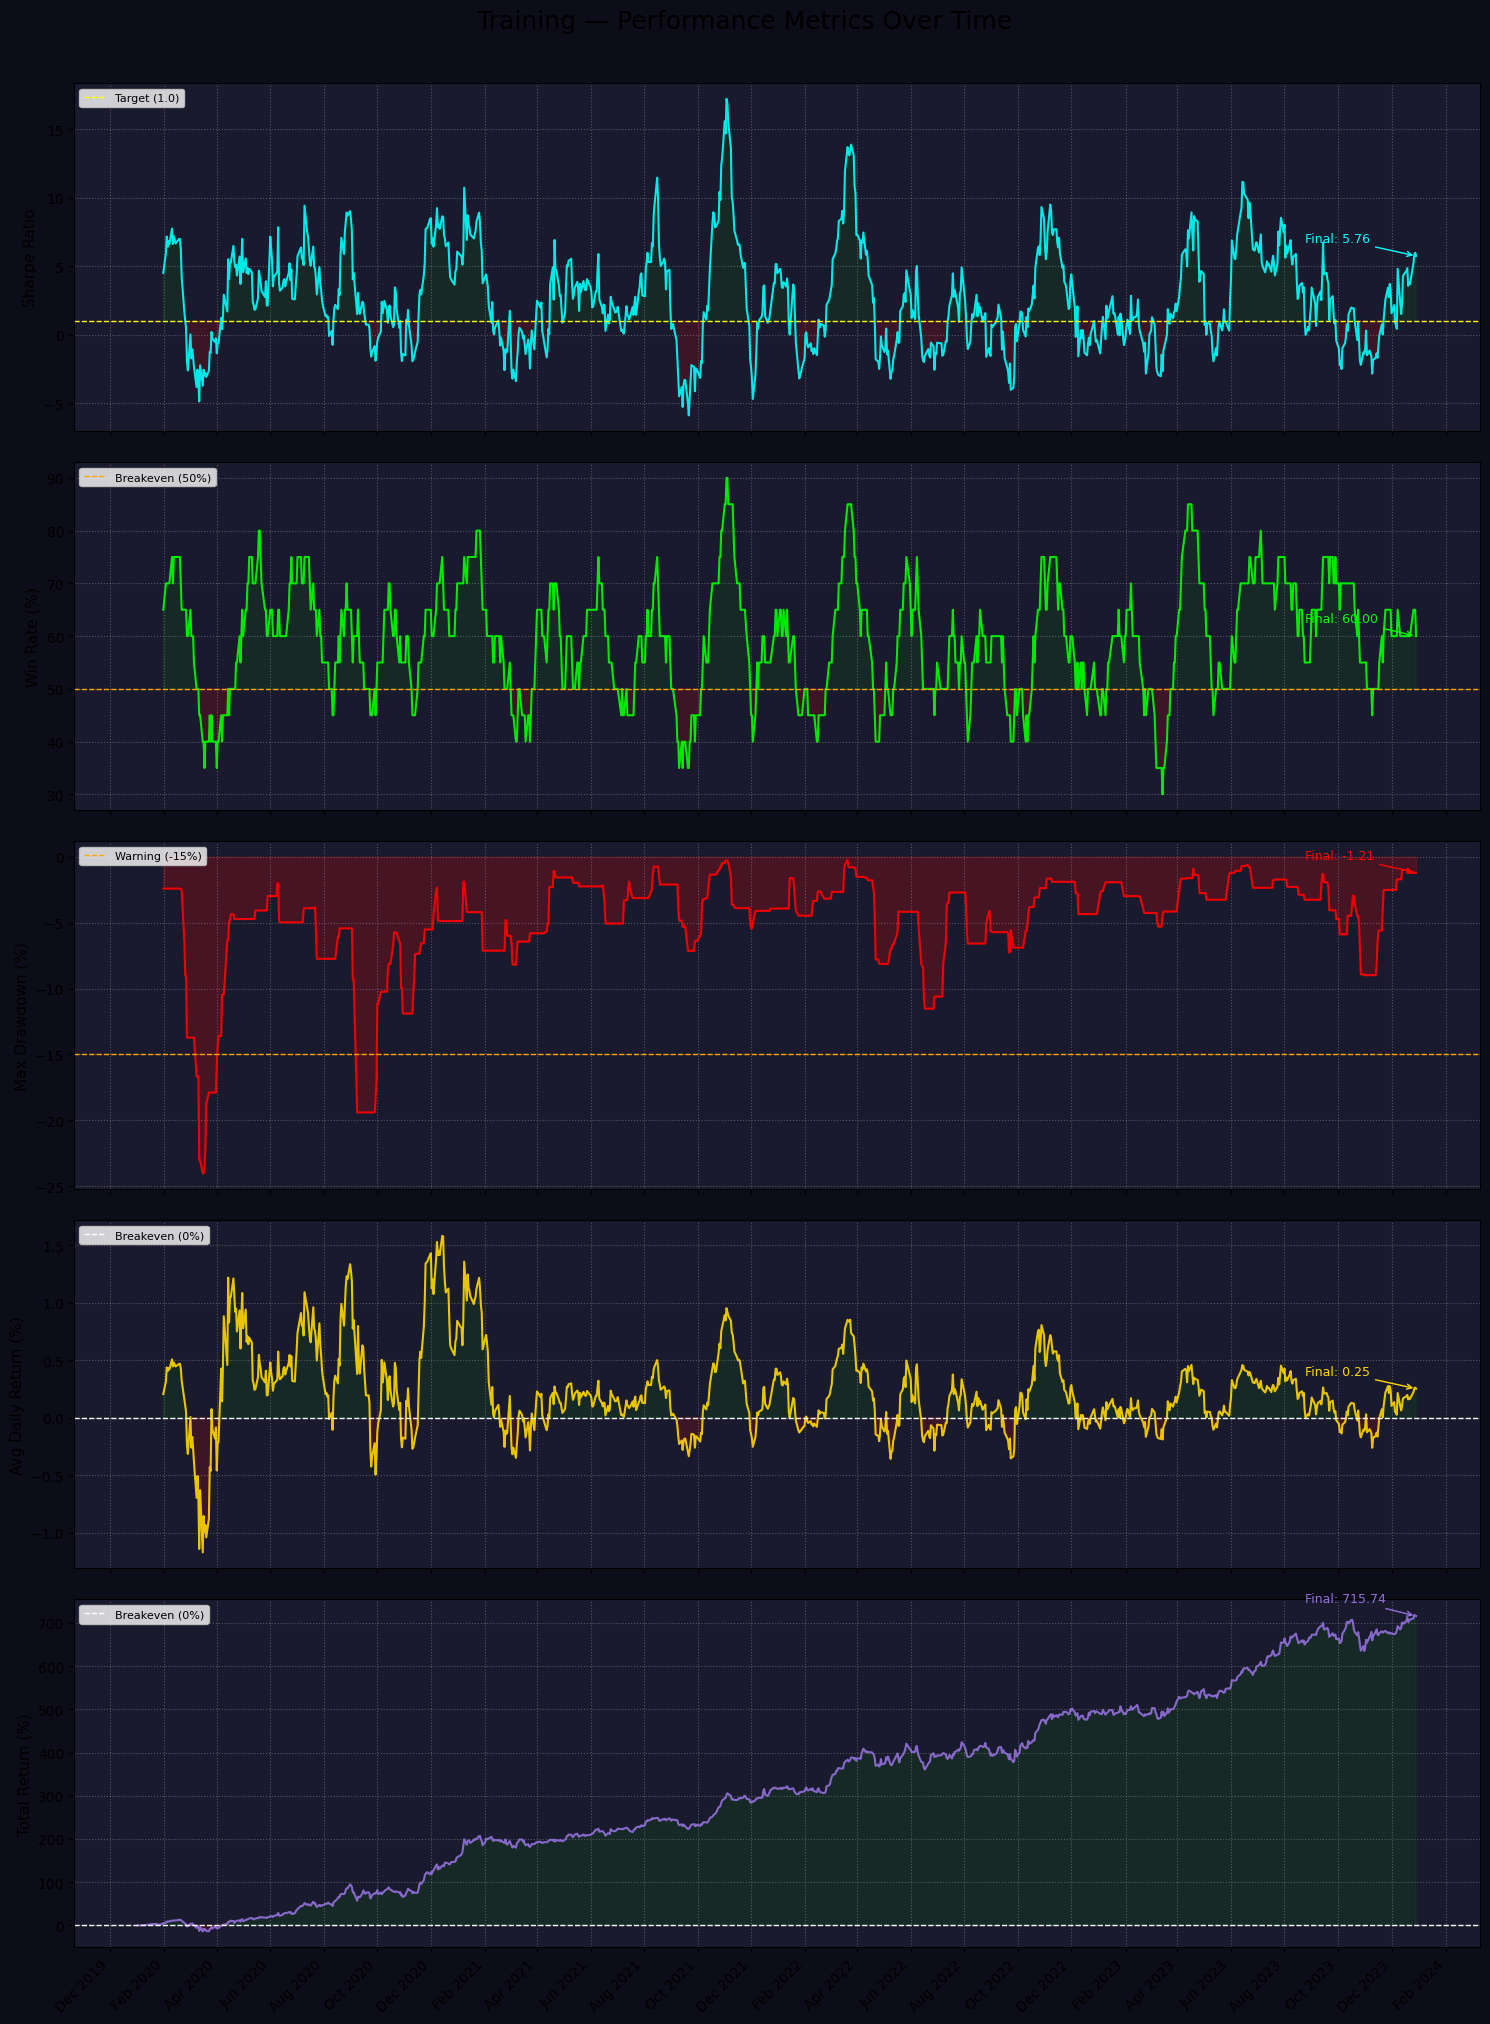


  TRAINING — FINAL METRIC VALUES
  Sharpe Ratio                   5.760
  Win Rate (%)                  60.000
  Max Drawdown (%)              -1.206
  Avg Daily Return (%)           0.251
  Total Return (%)             715.741
Computing test metrics...


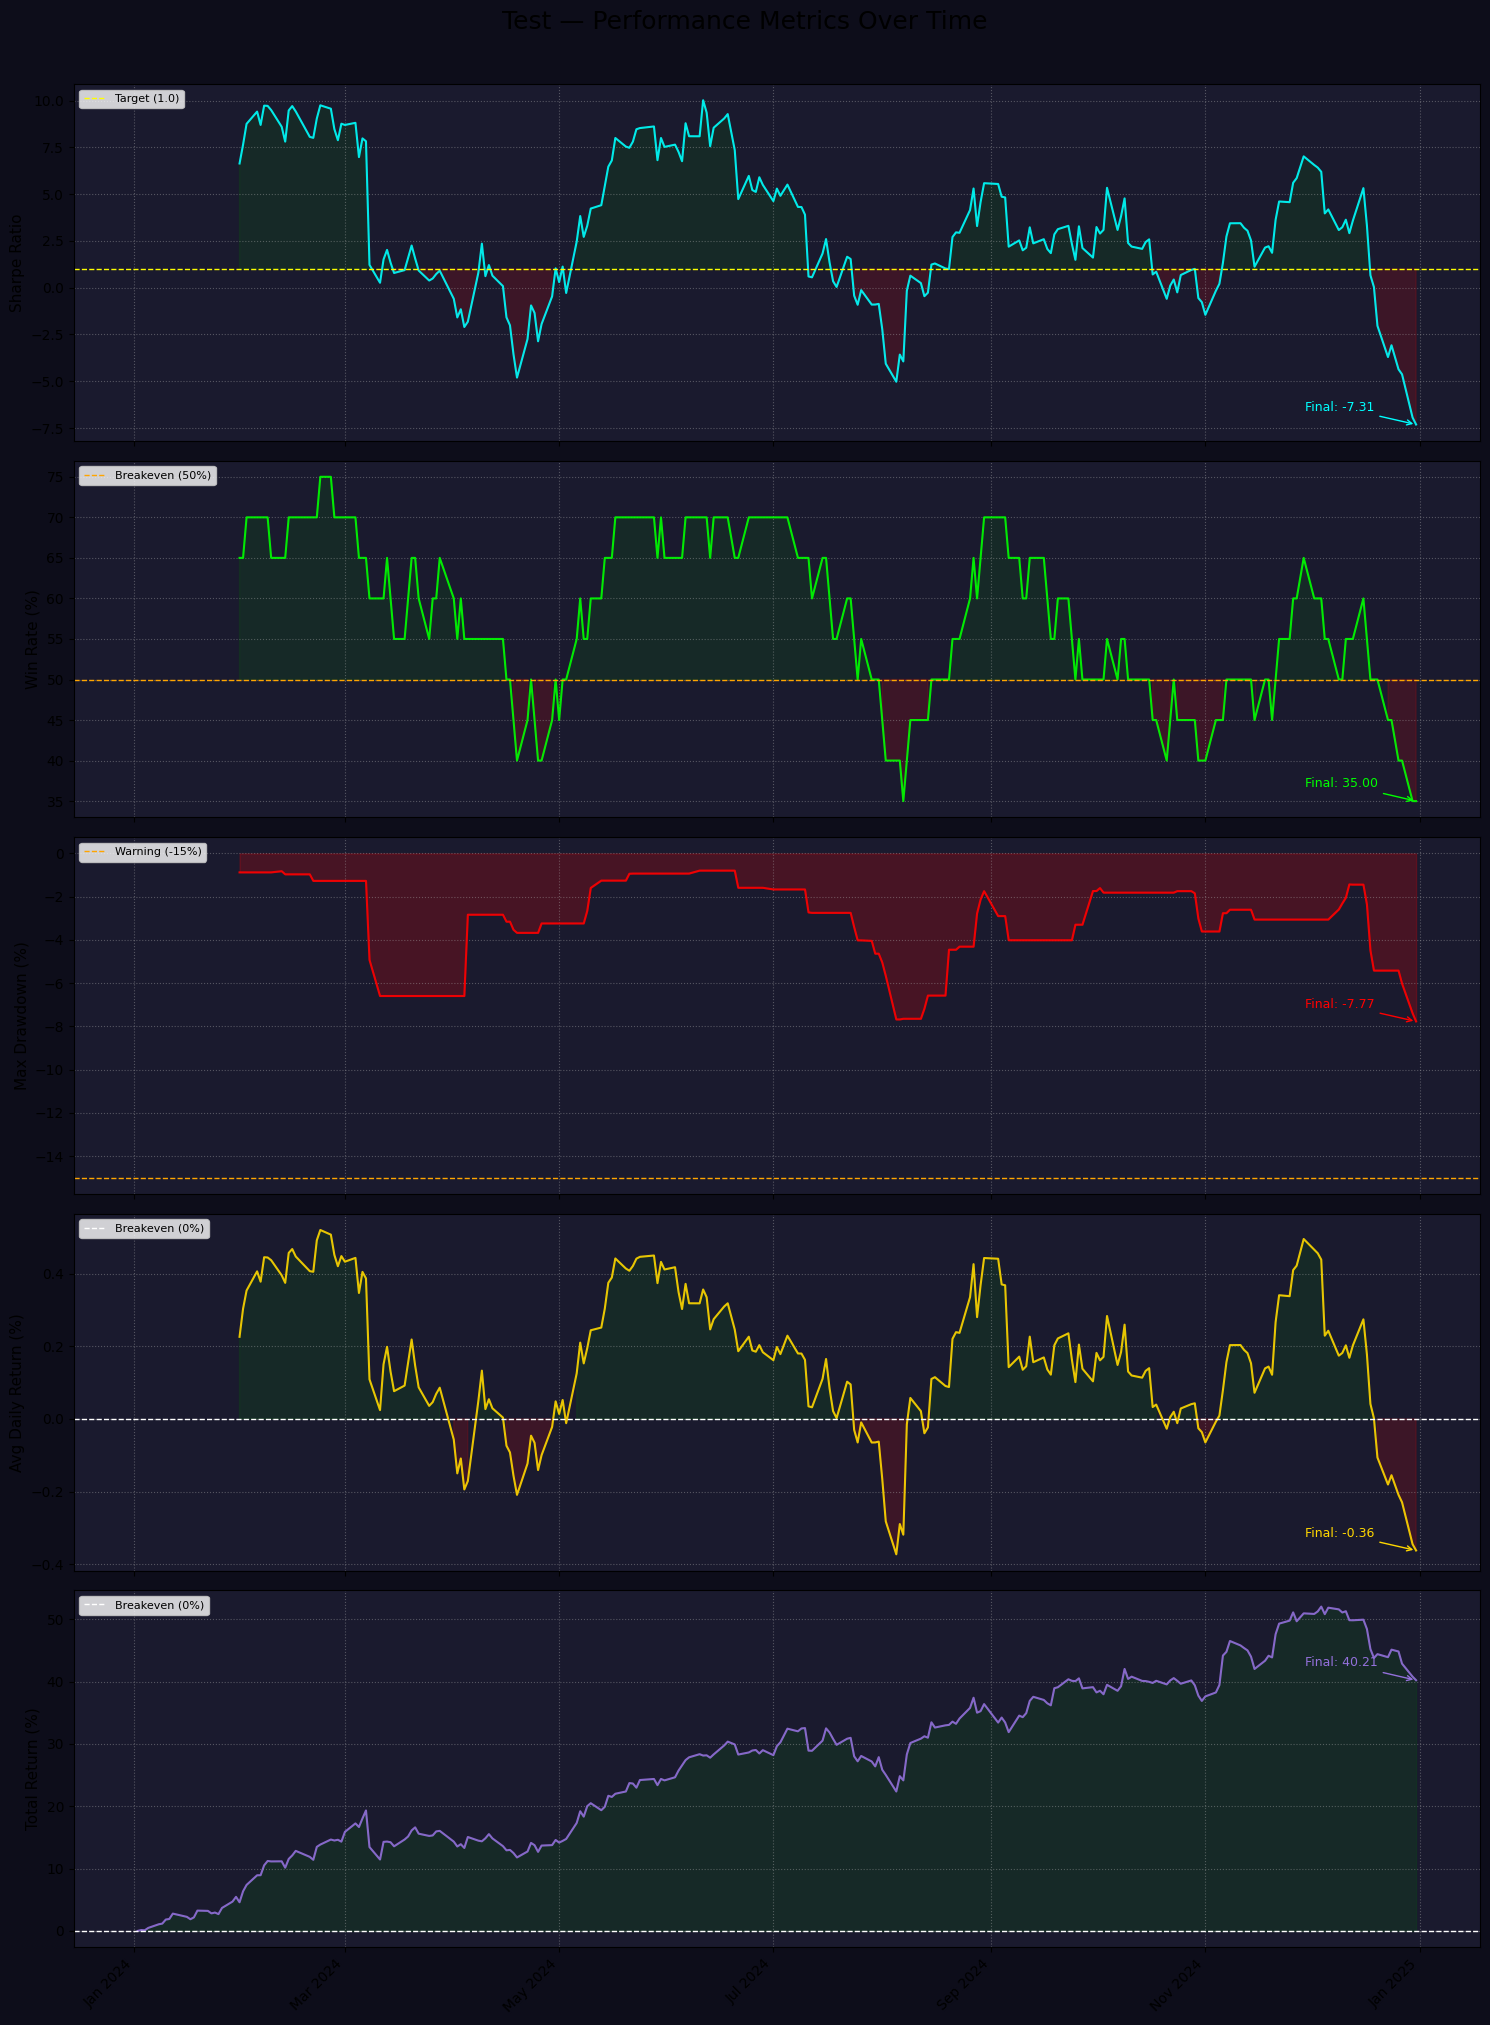


  TEST — FINAL METRIC VALUES
  Sharpe Ratio                  -7.313
  Win Rate (%)                  35.000
  Max Drawdown (%)              -7.771
  Avg Daily Return (%)          -0.362
  Total Return (%)              40.212


In [24]:
# ============================================================
# CELL 6b — Plot Metrics Over Time
# ============================================================

def compute_rolling_metrics(df_account_value: pd.DataFrame,
                             initial_capital: float = 1_000_000,
                             window: int = 20) -> pd.DataFrame:
    """
    Compute rolling metrics over time so we can plot how each
    metric evolves over the course of the model's trading history.

    window: rolling window in trading days (default 20 = 1 month)
    """
    values = pd.Series(
        df_account_value['account_value'].values,
        index=pd.to_datetime(df_account_value['date'].values)
    )

    daily_returns = values.pct_change().dropna()

    # Rolling Sharpe (annualised)
    rolling_sharpe = (
        daily_returns.rolling(window).mean() /
        daily_returns.rolling(window).std()
    ) * np.sqrt(252)

    # Rolling Win Rate
    rolling_win_rate = (
        daily_returns.rolling(window)
        .apply(lambda x: (x > 0).sum() / len(x) * 100)
    )

    # Rolling Max Drawdown
    def rolling_max_drawdown(returns):
        cum    = (1 + returns).cumprod()
        peak   = cum.cummax()
        dd     = (cum - peak) / peak * 100
        return dd.min()

    rolling_max_dd = (
        daily_returns.rolling(window)
        .apply(rolling_max_drawdown)
    )

    # Rolling Avg Daily Return
    rolling_avg_return = daily_returns.rolling(window).mean() * 100

    # Cumulative Total Return over time
    total_return = (values - initial_capital) / initial_capital * 100

    metrics_df = pd.DataFrame({
        'Sharpe Ratio':         rolling_sharpe,
        'Win Rate (%)':         rolling_win_rate,
        'Max Drawdown (%)':     rolling_max_dd,
        'Avg Daily Return (%)': rolling_avg_return,
        'Total Return (%)':     total_return,
    })

    return metrics_df


def plot_metrics(metrics_df: pd.DataFrame, title_prefix: str = 'Training'):
    """
    Plot all five metrics in a clean multi-panel figure.
    Each metric gets its own subplot with appropriate colouring.
    """
    fig, axes = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
    fig.suptitle(f'{title_prefix} — Performance Metrics Over Time',
                 fontsize=18, y=1.01)

    plot_config = [
        {
            'col':    'Sharpe Ratio',
            'color':  'cyan',
            'ylabel': 'Sharpe Ratio',
            'hline':  1.0,
            'hline_label': 'Target (1.0)',
            'hline_color': 'yellow',
        },
        {
            'col':    'Win Rate (%)',
            'color':  'lime',
            'ylabel': 'Win Rate (%)',
            'hline':  50.0,
            'hline_label': 'Breakeven (50%)',
            'hline_color': 'orange',
        },
        {
            'col':    'Max Drawdown (%)',
            'color':  'red',
            'ylabel': 'Max Drawdown (%)',
            'hline':  -15.0,
            'hline_label': 'Warning (-15%)',
            'hline_color': 'orange',
        },
        {
            'col':    'Avg Daily Return (%)',
            'color':  'gold',
            'ylabel': 'Avg Daily Return (%)',
            'hline':  0.0,
            'hline_label': 'Breakeven (0%)',
            'hline_color': 'white',
        },
        {
            'col':    'Total Return (%)',
            'color':  'mediumpurple',
            'ylabel': 'Total Return (%)',
            'hline':  0.0,
            'hline_label': 'Breakeven (0%)',
            'hline_color': 'white',
        },
    ]

    for ax, cfg in zip(axes, plot_config):
        series = metrics_df[cfg['col']].dropna()

        ax.plot(series.index, series.values,
                color=cfg['color'], linewidth=1.5, alpha=0.9)

        # Fill above/below reference line
        ax.axhline(cfg['hline'], color=cfg['hline_color'],
                   linestyle='--', linewidth=1, label=cfg['hline_label'])

        if cfg['col'] == 'Max Drawdown (%)':
            # Always fill red for drawdown
            ax.fill_between(series.index, series.values, 0,
                            alpha=0.2, color='red')
        else:
            ax.fill_between(series.index, series.values, cfg['hline'],
                            where=series.values >= cfg['hline'],
                            alpha=0.15, color='green')
            ax.fill_between(series.index, series.values, cfg['hline'],
                            where=series.values < cfg['hline'],
                            alpha=0.15, color='red')

        ax.set_ylabel(cfg['ylabel'], fontsize=11)
        ax.legend(loc='upper left', fontsize=8)
        ax.grid(True, linestyle=':', alpha=0.4)
        ax.set_facecolor('#1a1a2e')

        # Annotate final value
        final_val = series.iloc[-1] if len(series) > 0 else 0
        ax.annotate(
            f'Final: {final_val:.2f}',
            xy=(series.index[-1], final_val),
            xytext=(-80, 10),
            textcoords='offset points',
            fontsize=9,
            color=cfg['color'],
            arrowprops=dict(arrowstyle='->', color=cfg['color'], lw=1)
        )

        # Format x axis dates
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.setp(axes[-1].get_xticklabels(), rotation=45, ha='right')
    fig.patch.set_facecolor('#0d0d1a')
    fig.tight_layout()
    plt.show()

    # ── Summary table ─────────────────────────────────────────
    final_metrics = metrics_df.iloc[-1]
    print(f"\n{'='*50}")
    print(f"  {title_prefix.upper()} — FINAL METRIC VALUES")
    print(f"{'='*50}")
    for col in metrics_df.columns:
        val = final_metrics[col]
        print(f"  {col:<25} {val:>10.3f}")
    print(f"{'='*50}")


# ── Run for training ──────────────────────────────────────────
print("Computing training metrics...")
train_rolling = compute_rolling_metrics(df_train_account, window=20)
plot_metrics(train_rolling, title_prefix='Training')

# ── Run for test ──────────────────────────────────────────────
print("Computing test metrics...")
test_rolling = compute_rolling_metrics(df_account_value, window=20)
plot_metrics(test_rolling, title_prefix='Test')

hit end!


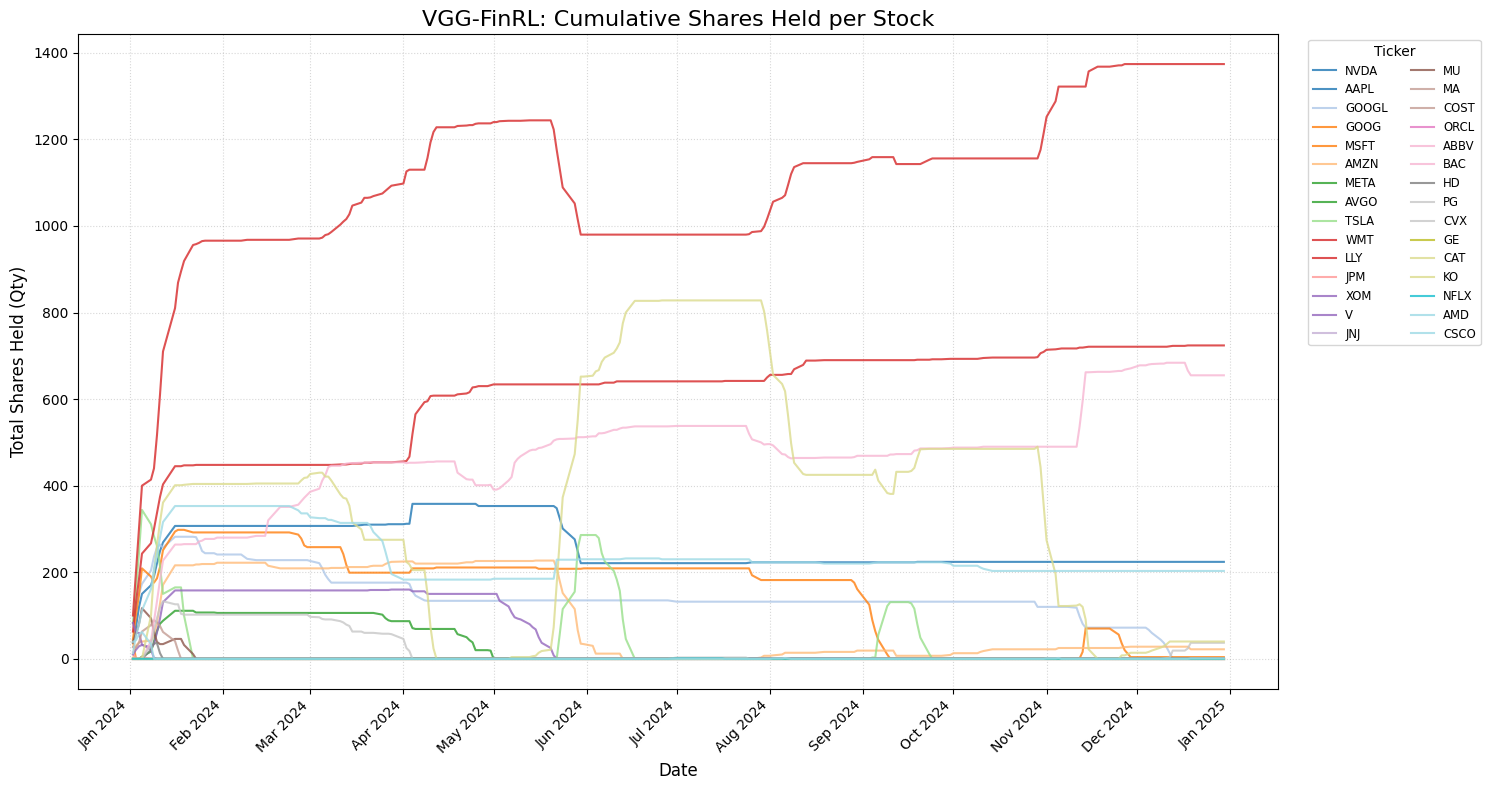

In [25]:
# ============================================================
# CELL 7 — Run Prediction & Plot Cumulative Shares Held
# ============================================================
import matplotlib.dates as mdates
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_vgg,
    environment=e_test_gym
)

# Parse dates as proper datetime
df_shares_held = df_actions.cumsum()
dates_all      = pd.to_datetime(df_account_value['date'].values)

min_len     = min(len(dates_all), len(df_shares_held))
dates_plot  = dates_all[:min_len]
shares_plot = df_shares_held.iloc[:min_len]

fig, ax = plt.subplots(figsize=(15, 8))
colormap = plt.get_cmap('tab20', len(TICKERS))

for i, ticker in enumerate(TICKERS):
    if ticker in shares_plot.columns:
        ax.plot(dates_plot, shares_plot[ticker], label=ticker,
                color=colormap(i), linewidth=1.5, alpha=0.8)

# Format x-axis as proper dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title('VGG-FinRL: Cumulative Shares Held per Stock', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Shares Held (Qty)', fontsize=12)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=2, fontsize='small', title='Ticker')
ax.grid(True, linestyle=':', alpha=0.5)
fig.tight_layout()
plt.show()


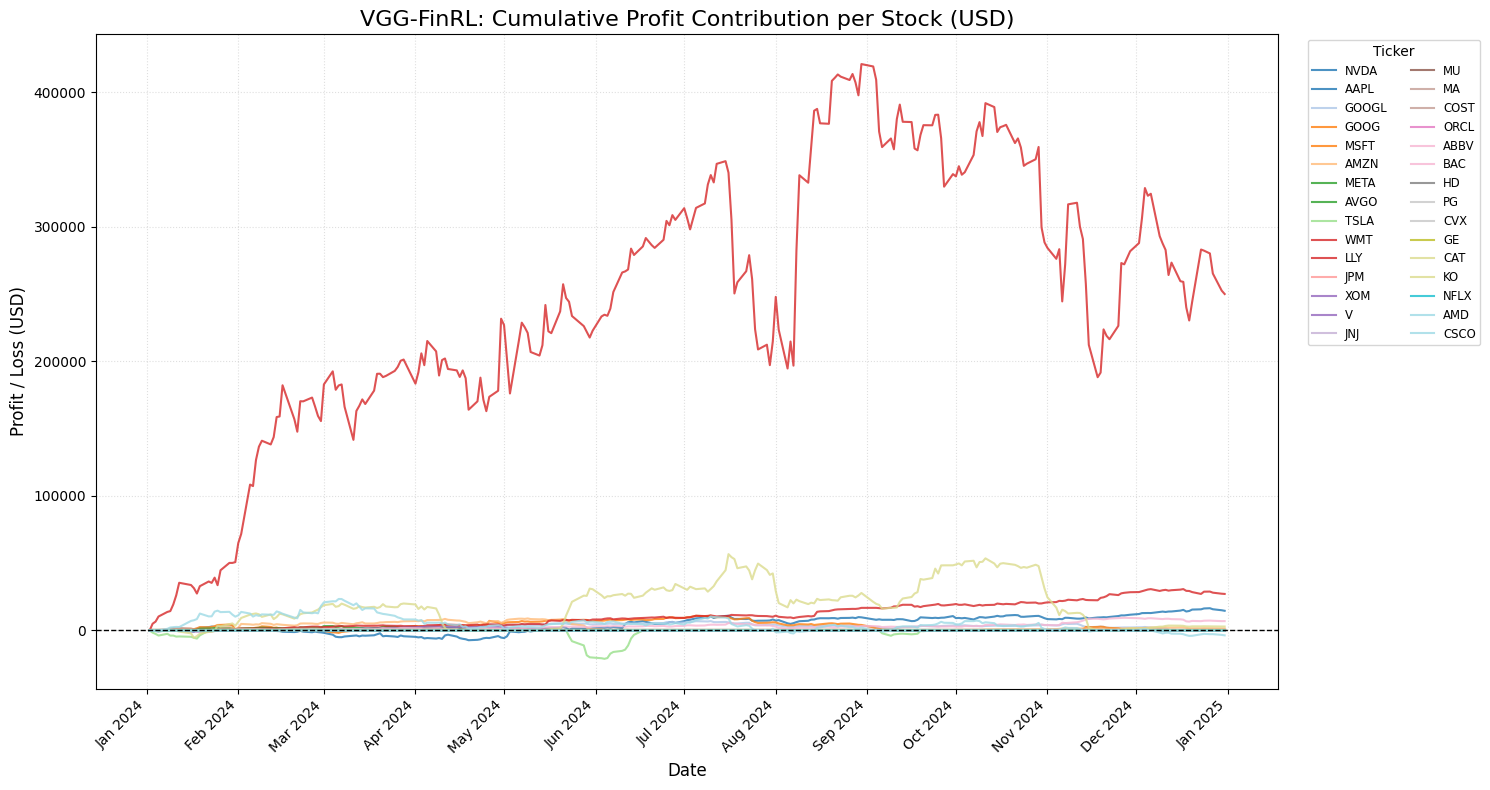

In [26]:
# ============================================================
# CELL 8 — Plot Profit Contribution per Stock
# ============================================================
# Pivot prices and join on date index so alignment is guaranteed
df_prices_pivot = (
    e_test_gym.df
    .sort_values(['date', 'tic'])
    .pivot(index='date', columns='tic', values='close')
)

df_shares_held = df_actions.cumsum()
df_shares_held.index = dates_all[:len(df_shares_held)]  # align by date (already datetime)

# Cast price index to datetime, then reindex and forward-fill
price_dates           = pd.to_datetime(df_prices_pivot.index)
df_prices_pivot.index = price_dates
df_shares_aligned     = df_shares_held.reindex(price_dates).ffill().fillna(0)

profit_df = pd.DataFrame(index=price_dates)
for ticker in TICKERS:
    if ticker in df_prices_pivot.columns and ticker in df_shares_aligned.columns:
        prices        = df_prices_pivot[ticker]
        initial_price = prices.iloc[0]
        profit_df[ticker] = (prices - initial_price) * df_shares_aligned[ticker]

fig, ax = plt.subplots(figsize=(15, 8))
colormap = plt.get_cmap('tab20', len(TICKERS))

for i, ticker in enumerate(TICKERS):
    if ticker in profit_df.columns:
        ax.plot(profit_df.index, profit_df[ticker], label=ticker,
                color=colormap(i), linewidth=1.5, alpha=0.8)

ax.axhline(0, color='black', lw=1, linestyle='--')

# Format x-axis as proper dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title('VGG-FinRL: Cumulative Profit Contribution per Stock (USD)', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Profit / Loss (USD)', fontsize=12)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=2, fontsize='small', title='Ticker')
ax.grid(True, linestyle=':', alpha=0.4)
fig.tight_layout()
plt.show()

In [27]:
# ============================================================
# CELL 9 — Compute True P&L (Current Holding Value)
# ============================================================
true_pnl_df = (df_prices_pivot * df_shares_aligned).fillna(0)
true_pnl_df = true_pnl_df.reset_index().rename(columns={'date': 'Date'})

In [28]:
!pip install --upgrade nbformat

In [29]:
# ============================================================
# CELL 10 — Interactive Plotly P&L Chart
# ============================================================
final_pnl   = true_pnl_df[TICKERS].iloc[-1]
top_5       = final_pnl.nlargest(5).index.tolist()
bottom_5    = final_pnl.nsmallest(5).index.tolist()
key_tickers = set(top_5 + bottom_5)

fig = go.Figure()

for ticker in TICKERS:
    if ticker not in true_pnl_df.columns:
        continue
    fig.add_trace(go.Scatter(
        x=true_pnl_df['Date'],
        y=true_pnl_df[ticker],
        name=ticker,
        mode='lines',
        visible=True if ticker in key_tickers else 'legendonly',
        hovertemplate=f"<b>{ticker}</b><br>PnL: %{{y:$.2f}}<br>Date: %{{x}}<extra></extra>"
    ))

fig.update_layout(
    title='VGG-FinRL: Individual Stock P&L (Hover over lines to see details)',
    template='plotly_dark',
    hovermode='closest',
    hoverlabel=dict(bgcolor='black', font_size=13),
    xaxis_title='Date',
    yaxis_title='Profit / Loss (USD)',
    legend=dict(groupclick='toggleitem', traceorder='grouped')
)
fig.update_xaxes(rangeslider_visible=True)
#fig.write_html("pnl_chart.html")
#print("Open pnl_chart.html in your browser")
fig.show()

Future window: 2026-01-24 → 2026-02-22
Fetching Alpaca data: 2026-01-24 → 2026-02-22 for 30 tickers...
Alpaca data fetched — shape: (570, 8)
Date range: 2026-01-26 → 2026-02-20
Tickers: 30
Successfully added technical indicators
Fetching live NewsAPI sentiment...
✅ Loaded sentiment from cache: sentiment_future.pkl (fetched today, 30 requests used)
Sentiment merged — non-zero rows: 348 / 570
Future ready — 19 trading days
hit end!


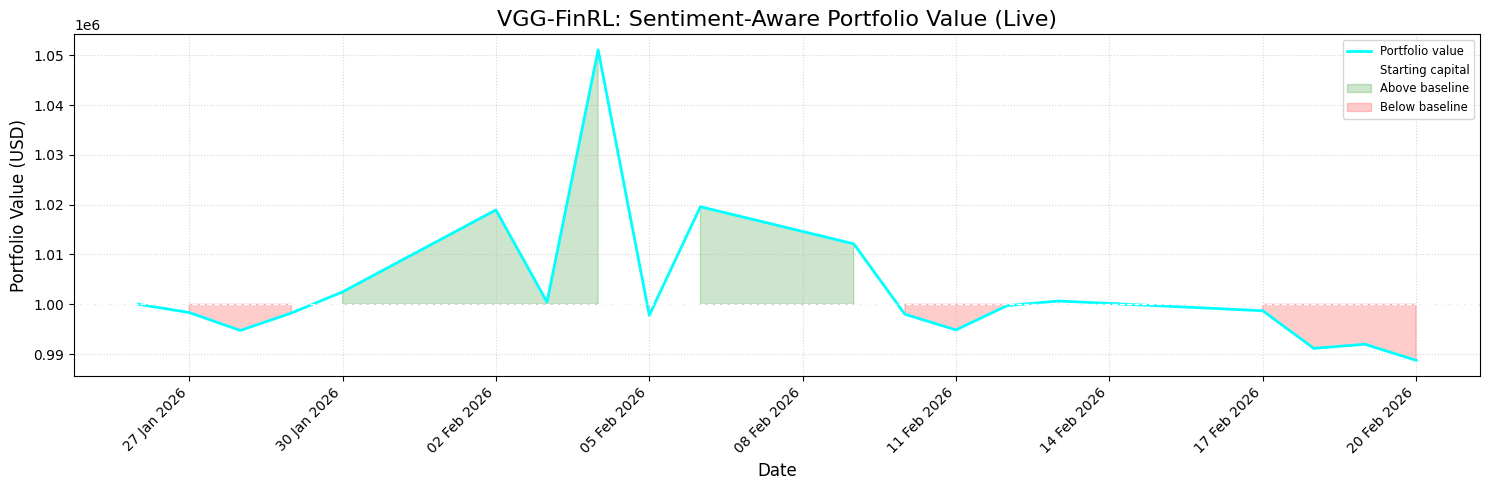

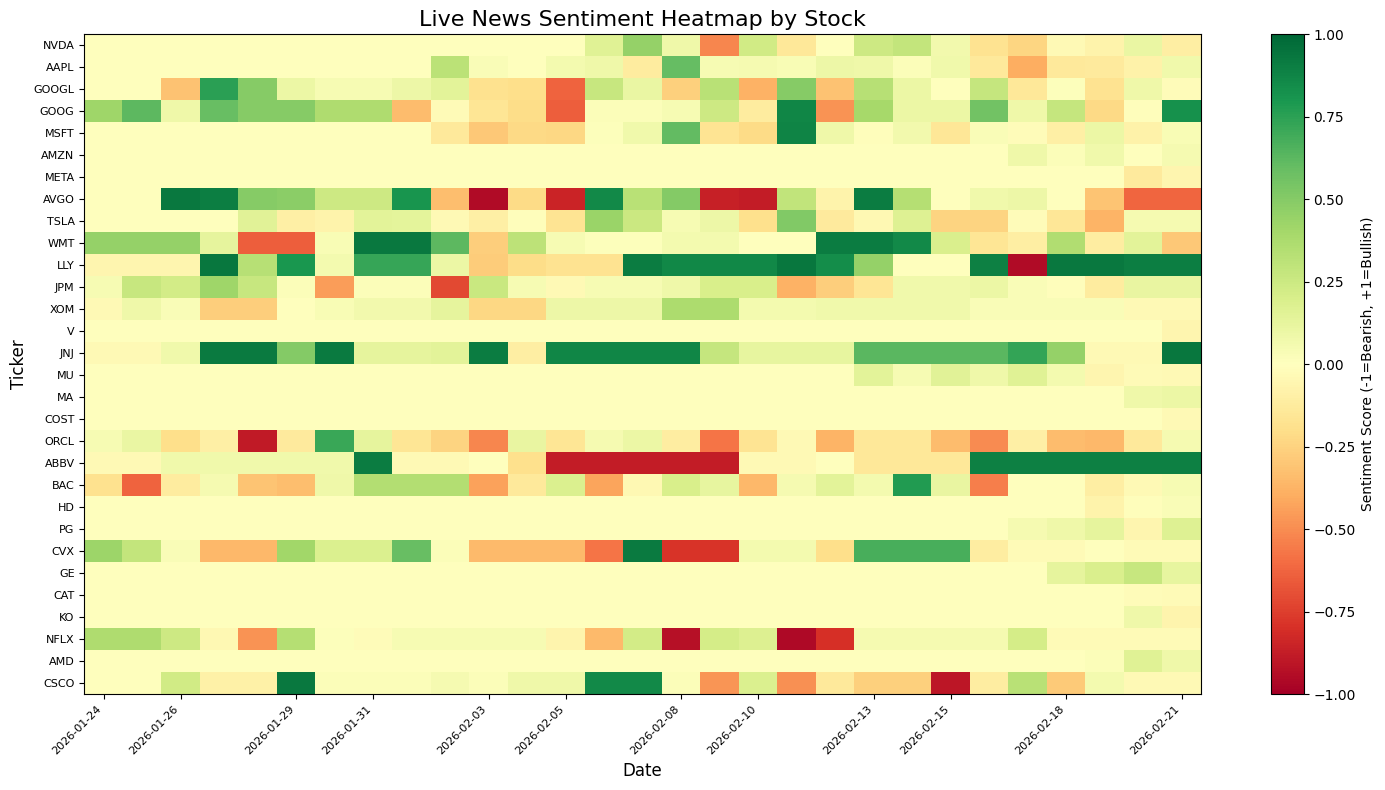

Chart saved to live_sentiment_pnl.html


In [30]:
# ============================================================
# CELL 11 — Future Prediction with Alpaca Live Data
# ============================================================
TODAY        = date.today()
DAYS_LIMIT   = 29
FUTURE_START = (TODAY - timedelta(days=DAYS_LIMIT)).strftime('%Y-%m-%d')
FUTURE_END   = TODAY.strftime('%Y-%m-%d')

print(f"Future window: {FUTURE_START} → {FUTURE_END}")

# Fetch recent price data via Alpaca
df_raw_future = fetch_alpaca_data(TICKERS, FUTURE_START, FUTURE_END)
df_future_raw = fe.preprocess_data(df_raw_future)

# Fetch live sentiment
print("Fetching live NewsAPI sentiment...")
df_sent_future = build_sentiment_df_cached(
    TICKERS,
    FUTURE_START,
    FUTURE_END,
    cache_file='sentiment_future.pkl'
)

df_future = prepare_df(df_future_raw, df_sent_future)
print(f"Future ready — {df_future['date'].nunique()} trading days")

e_future_gym = make_env(df_future)

df_future_account, df_future_actions = DRLAgent.DRL_prediction(
    model=trained_vgg,
    environment=e_future_gym
)

# ── Plot: Portfolio Value ─────────────────────────────────────
future_dates = pd.to_datetime(df_future_account['date'].values)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(future_dates, df_future_account['account_value'],
        color='cyan', linewidth=2, label='Portfolio value')
ax.axhline(1_000_000, color='white', linestyle='--',
           linewidth=1, label='Starting capital')
ax.fill_between(future_dates, 1_000_000, df_future_account['account_value'],
                where=df_future_account['account_value'] >= 1_000_000,
                alpha=0.2, color='green', label='Above baseline')
ax.fill_between(future_dates, 1_000_000, df_future_account['account_value'],
                where=df_future_account['account_value'] < 1_000_000,
                alpha=0.2, color='red', label='Below baseline')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('VGG-FinRL: Sentiment-Aware Portfolio Value (Live)', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Value (USD)', fontsize=12)
ax.legend(fontsize='small')
ax.grid(True, linestyle=':', alpha=0.5)
fig.tight_layout()
plt.show()

# ── Plot: Sentiment Heatmap ───────────────────────────────────
fig, ax = plt.subplots(figsize=(15, 8))
sent_plot = df_sent_future[TICKERS].T
im = ax.imshow(sent_plot.values, aspect='auto', cmap='RdYlGn',
               vmin=-1, vmax=1, interpolation='nearest')
ax.set_yticks(range(len(TICKERS)))
ax.set_yticklabels(TICKERS, fontsize=8)
n_cols   = sent_plot.shape[1]
tick_idx = np.linspace(0, n_cols - 1, min(12, n_cols)).astype(int)
ax.set_xticks(tick_idx)
ax.set_xticklabels(
    [sent_plot.columns[i] for i in tick_idx],
    rotation=45, ha='right', fontsize=8
)
plt.colorbar(im, ax=ax, label='Sentiment Score (-1=Bearish, +1=Bullish)')
ax.set_title('Live News Sentiment Heatmap by Stock', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Ticker', fontsize=12)
fig.tight_layout()
plt.show()

# ── Interactive Plotly: Future P&L ───────────────────────────
df_future_prices = (
    e_future_gym.df
    .sort_values(['date', 'tic'])
    .pivot(index='date', columns='tic', values='close')
)
future_price_dates     = pd.to_datetime(df_future_prices.index)
df_future_prices.index = future_price_dates
future_shares          = df_future_actions.cumsum()
future_shares_aligned  = future_shares.reindex(future_price_dates).ffill().fillna(0)

future_pnl_df = pd.DataFrame(index=future_price_dates)
for ticker in TICKERS:
    if ticker in df_future_prices.columns and ticker in future_shares_aligned.columns:
        prices        = df_future_prices[ticker]
        initial_price = prices.iloc[0]
        future_pnl_df[ticker] = (prices - initial_price) * future_shares_aligned[ticker]

future_pnl_df    = future_pnl_df.reset_index().rename(columns={'date': 'Date'})
final_future_pnl = future_pnl_df[TICKERS].iloc[-1]
top_5            = final_future_pnl.nlargest(5).index.tolist()
bottom_5         = final_future_pnl.nsmallest(5).index.tolist()
key_tickers      = set(top_5 + bottom_5)

fig = go.Figure()
for ticker in TICKERS:
    if ticker not in future_pnl_df.columns:
        continue
    fig.add_trace(go.Scatter(
        x=future_pnl_df['Date'],
        y=future_pnl_df[ticker],
        name=ticker,
        mode='lines',
        visible=True if ticker in key_tickers else 'legendonly',
        hovertemplate=f"<b>{ticker}</b><br>PnL: %{{y:$.2f}}<br>Date: %{{x}}<extra></extra>"
    ))
fig.update_layout(
    title='VGG-FinRL: Sentiment-Aware Individual Stock P&L (Live)',
    template='plotly_dark',
    hovermode='closest',
    hoverlabel=dict(bgcolor='black', font_size=13),
    xaxis_title='Date',
    yaxis_title='Profit / Loss (USD)',
    legend=dict(groupclick='toggleitem', traceorder='grouped')
)
fig.update_xaxes(rangeslider_visible=True)
fig.write_html("live_sentiment_pnl.html")
print("Chart saved to live_sentiment_pnl.html")

In [31]:
df_train.to_csv('FinRLAlpaca_train.csv')
df_test.to_csv('FinRLAlpaca_validation.csv')